# 1. Setup

In [1]:
from io import BytesIO
from urllib.request import urlopen

from sklearn.linear_model import LinearRegression
from zipfile import ZipFile

from utils import *

# 2. Prepare data

## 2.1. Download

In [2]:
def get_nhts():
    resp = urlopen('https://nhts.ornl.gov/assets/2016/download/csv.zip')
    z = ZipFile(BytesIO(resp.read()))
    for file in z.namelist():
        if file.split('.')[-1] != 'csv': continue
        table = file.split('.')[0][:-3]
        outdir = mkdir(DATA / 'nhts2017')
        z.extract(file, outdir)
        df = pd.read_csv(outdir / file).rename(columns=str.lower)
        df.to_parquet(outdir / f'{table}.parquet')
        (outdir / file).unlink()

# get_nhts() # t=0:20

## 2.2. Load tables

In [3]:
trips_raw = pd.read_parquet(DATA / 'nhts2017/trip.parquet').rename(columns=str.lower).disp()

923,572 rows x 115 cols; Memory: 1037.8 MiB


,houseid,personid,tdtrpnum,strttime,endtime,trvlcmin,trpmiles,trptrans,trpaccmp,trphhacc,...,obhtnrnt,obppopdn,obresdn,dthtnrnt,dtppopdn,dtresdn,dteempdn,dbhtnrnt,dbppopdn,dbresdn
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<float64>,<int64>,<int64>,<int64>,...,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300


In [4]:
# households table
hh_raw = pd.read_parquet(DATA / 'nhts2017/hh.parquet').rename(columns=str.lower).disp()

129,696 rows x 58 cols; Memory: 76.6 MiB


,houseid,travday,sampstrat,homeown,hhsize,hhvehcnt,hhfaminc,pc,sphone,tab,...,smplsrce,wthhfin,hbhur,hthtnrnt,htppopdn,htresdn,hteempdn,hbhtnrnt,hbppopdn,hbresdn
,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,...,<int64>,<float64>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,30000007,2,3,1,3,5,7,2,1,2,...,2,187.31432,T,50,1500,750,750,20,750,300


## 2.3. Process trips

In [5]:
def get_trip_data(trip=trips_raw, hh=hh_raw, seed=SEED):
    hh['VehOwn'] = hh['hhvehcnt'] / hh['numadlt']
    trip = trip.merge(hh[['houseid', 'VehOwn']])
    df = Pdf()
    def cut(col: str, bins: list[float], labels: list[str]) -> pd.Categorical:
        return pd.cut(trip[col], [-INF] + bins + [INF], True, labels)
    def classify(col: str, mapping: dict) -> pd.Categorical:
        cats = Series(list(mapping.values())).drop_duplicates().to_list()
        return pd.Categorical(trip[col].map(mapping), categories=cats)
    ## Add Gaussian noise to the duration values
    df['Time'], df['RawTime'] = [trip['trvlcmin']] * 2 # in minutes
    np.random.seed(seed)
    for mu in np.arange(5, 91, 5): # noisify every 5 minutes
        idx = df[df.Time == mu].index
        sample = np.random.normal(mu, 5 / 2, size=len(idx))
        df.loc[idx, 'Time'] = sample
    ## Other deterrence measures
    df['Distance'] = trip['trpmiles'] * MI2M / 1000 # in km
    df['Speed'] = (df.Distance / (df.Time / 60)) # in km/h
    for col, vmax in D(Distance=100, Time=120, Speed=100).items():
        df.loc[(df[col] <= 0) | (df[col] > vmax), col] = np.nan
    # ## Assign a flag to the rows about whether their peak duration values are sampled
    ## Trip attributes
    df['Purpose'] = classify('trippurp', D(HBW='HBW', HBSHOP='HBSHOP',
                                           HBSOCREC='HBSOC', HBO='HBO', NHB='NHB'))
    df['Mode'] = classify('trptrans', {x: 'Drive' for x in [3, 4, 5, 6, 17, 18]} | 
                                      {x: 'Transit' for x in [10, 11, 12, 13, 14, 15, 16]} |
                                      {1: 'Walk', 2: 'Bike'})
    df['Weekend'] = classify('tdwknd', {1: 'Yes', 2: 'No'})
    df['GasPrice'] = cut('gasprice', [233, 267], ['Low', 'Mid', 'High'])
    df['StayTime'] = cut('dweltime', [15, 60, 120, 480], ['Very short', 'Short', 'Mid', 'Long', 'Very long'])
    df['StartTime'] = (pd.cut(trip['strttime'], [0, 600, 900, 1600, 1900, 2400], labels=[
        'Off-peak', 'Morning Peak', 'Off-peak', 'Evening Peak', 'Off-peak'], ordered=False)
                       .cat.reorder_categories(['Morning Peak', 'Evening Peak', 'Off-peak']))
    ## Land use attributes
    # df['Region'] = cut('census_r', [1, 2, 3], ['Northeast', 'Midwest', 'South', 'West'])
    df['MSAKind'] = classify('msacat', {1: 'Big w/ MRT', 2: 'Big w/o MRT', 3: 'Small', 4: 'Small'})
    df['UrbanO'] = classify('obhur', D(R='Rural', S='Suburban', T='Suburban', C='Urban', U='Urban'))
    df['UrbanD'] = classify('dbhur', D(R='Rural', S='Suburban', T='Suburban', C='Urban', U='Urban'))
    df['PopDensityO'] = cut('otppopdn', [0, 1000, 4000], ['n/a', 'Low', 'Mid', 'High'])
    df['PopDensityD'] = cut('dtppopdn', [0, 1000, 4000], ['n/a', 'Low', 'Mid', 'High'])
    df['HouseDensityO'] = cut('otresdn', [0, 500, 2000], ['n/a', 'Low', 'Mid', 'High'])
    df['HouseDensityD'] = cut('dtresdn', [0, 500, 2000], ['n/a', 'Low', 'Mid', 'High'])
    df['EmpDensityO'] = cut('oteempdn', [0, 500, 2000], ['n/a', 'Low', 'Mid', 'High'])
    df['EmpDensityD'] = cut('dteempdn', [0, 500, 2000], ['n/a', 'Low', 'Mid', 'High'])
    ## SES of respondent/household
    df['Age'] = cut('r_age', [0, 30, 64], ['n/a', 'Young', 'Mid', 'Senior'])
    df['Sex'] = classify('r_sex', {1: 'Male', 2: 'Female'})
    df['Race'] = classify('hh_race', {1: 'White'} | {x: 'Non-White' for x in [2, 3, 4, 5, 6]})
    df['Hispanic'] = classify('hh_hisp', {1: 'Yes', 2: 'No'})
    df['Education'] = cut('educ', [0, 2], ['n/a', 'School', 'College'])
    df['Worker'] = classify('worker', {1: 'Yes', 2: 'No'})
    df['Income'] = cut('hhfaminc', [0, 5, 7], ['n/a', 'Low', 'Mid', 'High'])
    df['HomeOwn'] = classify('homeown', {1: 'Own', 2: 'Rent'})
    df['VehOwn'] = cut('VehOwn', [0.999], ['Low', 'High'])
    ## Remove bad data
    for mode, max_speed in D(Walk=20, Bike=40, Transit=80).items():
        df = df[~((df.Mode == mode) & (df.Speed > max_speed))]
    df = df.replace('n/a', None)
    print('NaNs: ' + ' '.join([f'{k}={v:,}' for k, v in df.isna().sum().items() if v > 0]))
    df = df.dropna().reset_index(drop=1)
    for col in df.select_dtypes('object'):
        df[col] = df[col].astype(CAT)
    ## Add sample weights
    counts = df.select_dtypes(CAT).value_counts()
    wts = (1 / counts).rename('Weight').reset_index()
    df = df.merge(wts, on=list(wts.columns)[:-1])
    return df

trips = get_trip_data().disp()

NaNs: Time=15,933 Distance=20,825 Speed=30,852 Purpose=32 Mode=9,540 StartTime=543 UrbanO=975 UrbanD=958 PopDensityO=968 PopDensityD=951 HouseDensityO=968 HouseDensityD=951 EmpDensityO=968 EmpDensityD=951 Age=1,215 Sex=707 Race=19,482 Hispanic=988 Education=65,352 Worker=79,023 Income=24,246 HomeOwn=6,278
747,088 rows x 29 cols; Memory: 45.6 MiB


,Time,RawTime,Distance,Speed,Purpose,Mode,Weekend,GasPrice,StayTime,StartTime,...,Age,Sex,Race,Hispanic,Education,Worker,Income,HomeOwn,VehOwn,Weight
,<float64>,<int64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<float64>
0,16.182075,15,8.439379,31.291583,HBO,Drive,No,Low,Long,Off-peak,...,Senior,Female,Non-White,No,College,No,Mid,Own,High,0.5


In [6]:
# for col in sorted(trips.select_dtypes(CAT)):
#     print('*' * 50)
#     print(trips[col].value_counts().sort_index())

## 2.4. Combine OD variables

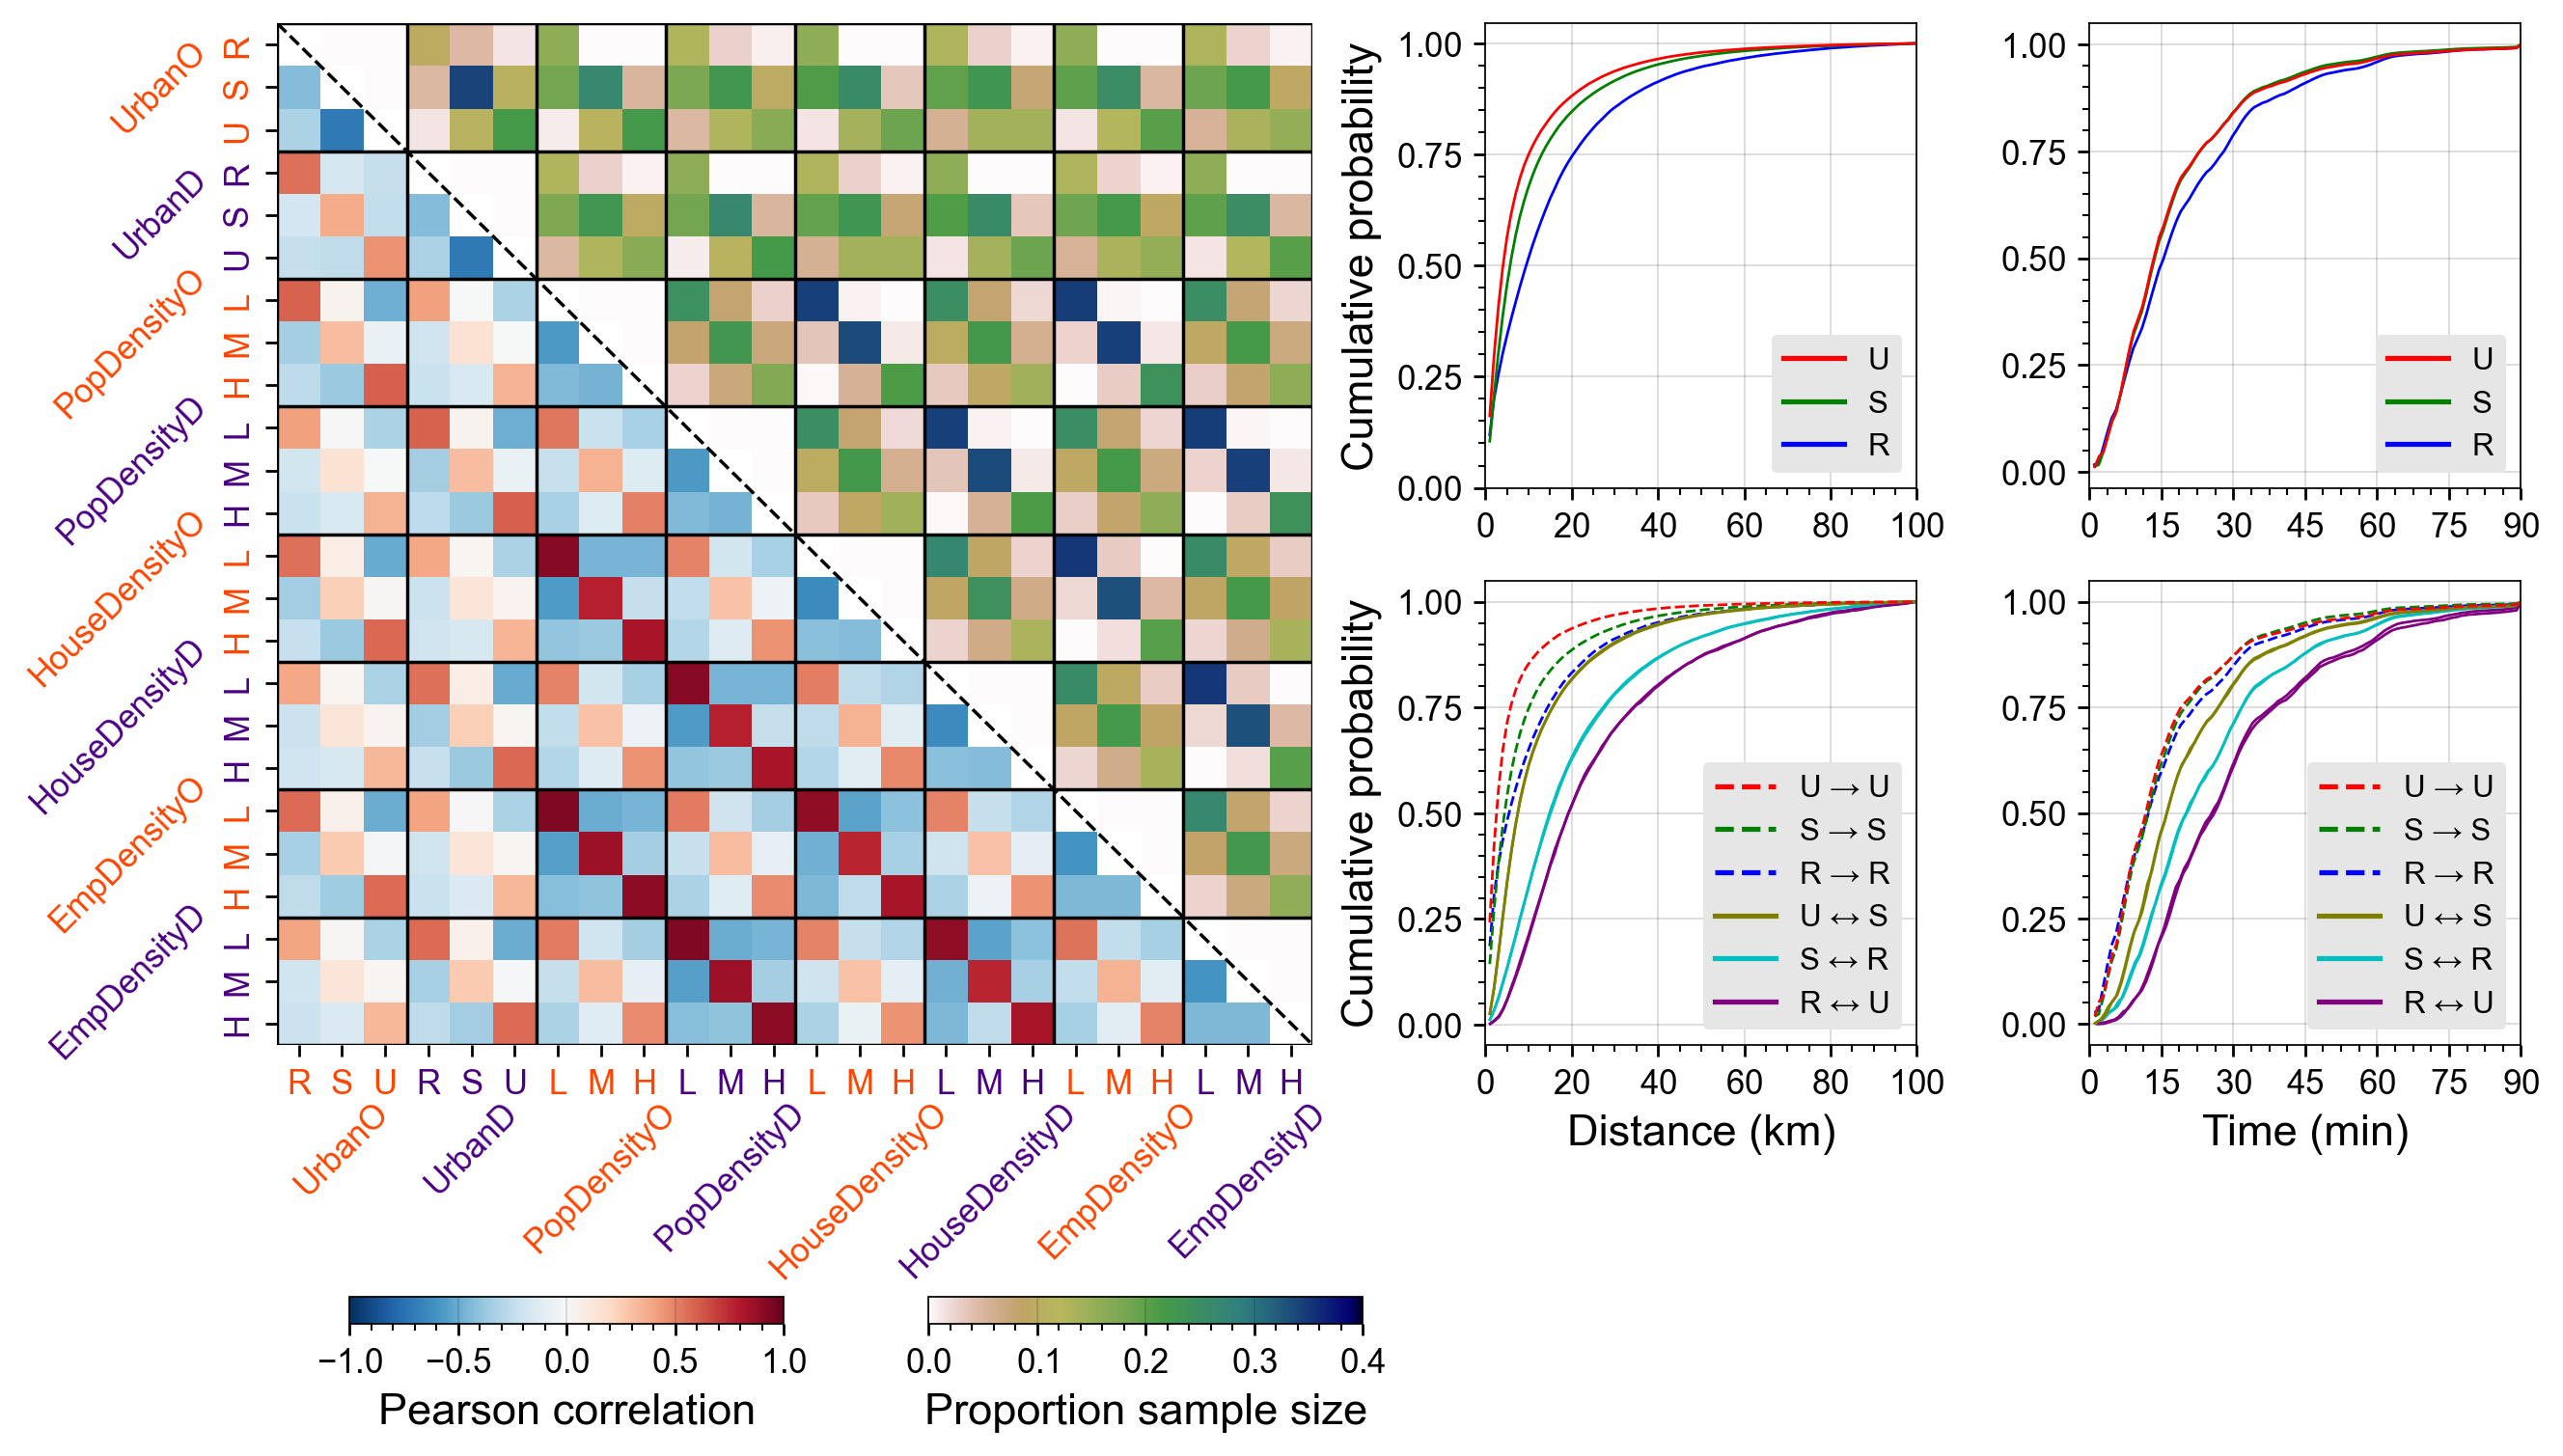

In [7]:
def fig_od_vars(trips=trips, eps=1e-5, size=(12, 5.5), dpi=150):
    feats = ('UrbanO UrbanD PopDensityO PopDensityD HouseDensityO '
             'HouseDensityD EmpDensityO EmpDensityD').split()
    X = pd.get_dummies(trips[feats], prefix_sep='__')
    fig = plt.figure(figsize=size, dpi=dpi)
    gs = fig.add_gridspec(2, 4, wspace=0.4)
    ## Panel 1
    corr = np.tril(X.corr(), -1)
    corr = np.where(corr == 0, np.nan, corr)
    N = np.zeros_like(corr, float) - 1
    for (ix, x), (iy, y) in it.combinations(list(enumerate(X.columns)), 2):
        N[ix, iy] = len(X[X[x] & X[y]]) / len(X)
    N = np.where(N == -1, np.nan, N)
    ax = pplot(fig.add_subplot(gs[:2, :2]), xminor=0, yminor=0, gridcolor='#ffff')
    labels = [x.split('__')[1][0] for x in X.columns]
    for mat, label, vmin, vmax, left, cmap in [
            (corr, 'Pearson correlation', -1, 1, 0.15, 'RdBu_r'),
            (N, 'Proportion sample size', 0, 0.4, 0.35, 'gist_earth_r')]:
        ax = sns.heatmap(mat, ax=ax, cmap=cmap, cbar=0, vmin=vmin, 
                         vmax=vmax, xticklabels=labels, yticklabels=labels)
        cax = fig.add_axes([left, -0.1, 0.15, 0.02])
        scale = mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin, vmax), cmap=cmap)
        fig.colorbar(scale, cax=cax, orientation='horizontal', label=label)
    cols = Pdf(D(col=X.columns))
    cols['feat'] = cols.col.str.split('__').str[0]
    cols['idx'] = (cols.feat.astype(CAT).cat.codes.diff() != 0)
    n = len(cols)
    for x in list(cols.idx[cols.idx].index) + [n]:
        ax.axvline(x, color='k', lw=1)
        ax.axhline(x, color='k', lw=1)
    ax.plot([0, n], [0, n], color='k', ls='--', lw=1)
    colors = D(O='orangered', D='indigo')
    for i, col in enumerate(feats):
        for x, y, ha, va in [(-1.5, i * 3 + 1.5, 'right', 'center'),
                             (i * 3 + 1.5, n + 1.2, 'center', 'top')]:
            ax.text(x, y, col, ha=ha, va=va, rotation=45, color=colors[col[-1]])
    tickcolors = np.repeat(np.tile(list(colors.values()), len(feats) // 2), 3)
    for labs in [ax.get_xticklabels(), ax.get_yticklabels()]:
        for lab, color in zip(labs, tickcolors):
            lab.set_color(color)
    ## Panel 2
    C1 = D(U='r', S='green', R='b') # single colors
    C2 = D(US='olive', SR='c', RU='purple') # unordered pairs
    C2 = {k*2: v for k, v in C1.items()} | C2
    C3 = C2 | {f'{k[1]}{k[0]}': v for k, v in C2.items()} # ordered pairs
    line = lambda label, **kw: mpl.lines.Line2D([0], [0], label=label, **kw)
    for i, target, vmin, vmax, gap, xlab in [
            (0, 'Distance', 0, 100, 20, 'Distance (km)'),
            (1, 'Time', 0, 90, 15, 'Time (min)')]:
        ## for OD vars
        ax1 = pplot(fig.add_subplot(gs[0, 2 + i]), xlim=(vmin, vmax + eps))
        for level, df in trips.groupby('UrbanO'):
            y, x = np.histogram(df[target].clip(vmin, vmax), bins=100)
            x, y = x[1:], (y / y.sum()).cumsum()
            ax1.plot(x, y, lw=0.8, label=level[0], color=C1[level[0]])
        ax1.legend(fontsize=9, loc='lower right', handles=[
             line(x, color=c) for x, c in C1.items()], framealpha=1)
        ## for flow var
        ax2 = pplot(fig.add_subplot(gs[1, 2 + i]), xlim=(vmin, vmax + 1e-5), xlab=xlab)
        for (src, trg), df in trips.groupby(['UrbanO', 'UrbanD']):
            s, t = src[0], trg[0]
            y, x = np.histogram(df[target].clip(vmin, vmax), bins=100)
            x, y = x[1:], (y / y.sum()).cumsum()
            ax2.plot(x, y, lw=0.8, color=C3[s + t], label=f'{s} → {t}',
                     ls='--' if s == t else '-')
        ax2.legend(fontsize=9, loc='lower right', handles=[
                line(label=f'{x} {"→" if x == y else "↔"} {y}', color=color,
                    ls='--' if x == y else '-')
                for (x, y), color in C2.items()], framealpha=1)
        for ax in [ax1, ax2]:
            ax.set_xticks(np.arange(vmin, vmax + 1e-5, gap))
            if i == 0: ax.set_ylabel('Cumulative probability')
            ax.set_yticks(np.arange(0, 1.01, .25))
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    imsave('Combining OD factors')

x = fig_od_vars(dpi=250); x # t=0:06

In [8]:
trips2 = trips.copy().assign(ODUrban=None)
keymap = D(UU='U → U', SS='S → S', RR='R → R', US='U ↔ S', SR='S ↔ R',
           RU='R ↔ U', SU='U ↔ S', RS='S ↔ R', UR='R ↔ U')
for (src, trg), df in trips.groupby(['UrbanO', 'UrbanD']):
    trips2.loc[df.index, 'ODUrban'] = keymap[src[0] + trg[0]]
trips2 = (
    trips2.assign(ODUrban=lambda df: pd.Categorical(
        df.ODUrban, categories=Series(keymap.values()).drop_duplicates()))
    [('Distance Time Speed Weight '
      'Purpose Mode Weekend GasPrice StayTime StartTime MSAKind '
      'Age Sex Race Hispanic Education Worker Income HomeOwn VehOwn').split()]
).disp(0)
trips2.to_parquet(DATA / 'trips.parquet')

747,088 rows x 20 cols; Memory: 34.2 MiB


,Distance,Time,Speed,Weight,Purpose,Mode,Weekend,GasPrice,StayTime,StartTime,MSAKind,Age,Sex,Race,Hispanic,Education,Worker,Income,HomeOwn,VehOwn
,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>


# 3. Analyze

## 3.1. Sample sizes

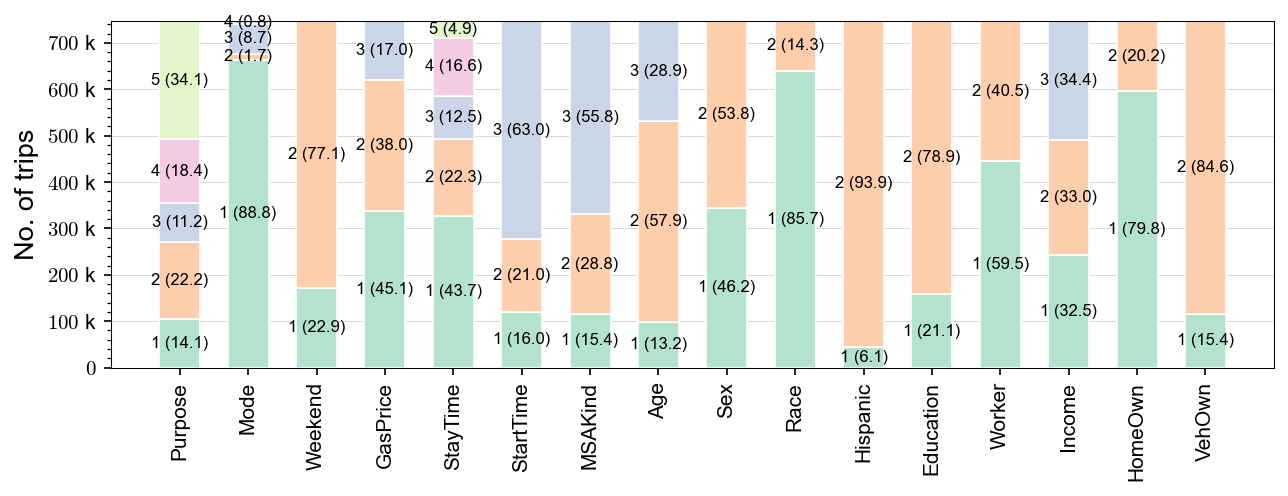

In [9]:
def plot_sample_sizes(trips, size=(10, 3), dpi=150, width=0.6, cmap='Pastel2'):
    cols = trips.select_dtypes(CAT).columns
    ax = pplot(size=size, dpi=dpi, ylab='No. of trips', yeng=1, xminor=0,
               xlim=(-1, len(cols)), ylim=(0, len(trips)))
    for i, col in enumerate(cols):
        df = trips[col].value_counts().rename('n').sort_index().reset_index()
        df['bottom'] = df.n.cumsum().shift().fillna(0)
        df['color'] = [mpl.colors.to_hex(x) for x in sns.color_palette(cmap, len(df))]
        for j, r in df.iterrows():
            ax.add_artist(mpl.patches.Rectangle(
                (i - width / 2, r.bottom), width, r.n, color=r.color, ec='w', lw=0.8))
            ax.text(i, r.bottom + r.n / 2, f'{j+1} ({r.n / len(trips) * 100:.1f})',
                    fontsize=8, ha='center', va='center')
    plt.xticks(range(len(cols)), cols, rotation=90)
    imsave('Sample size by factor level')

plot_sample_sizes(trips2, dpi=150)

## 3.2. Target vars (deterrence)

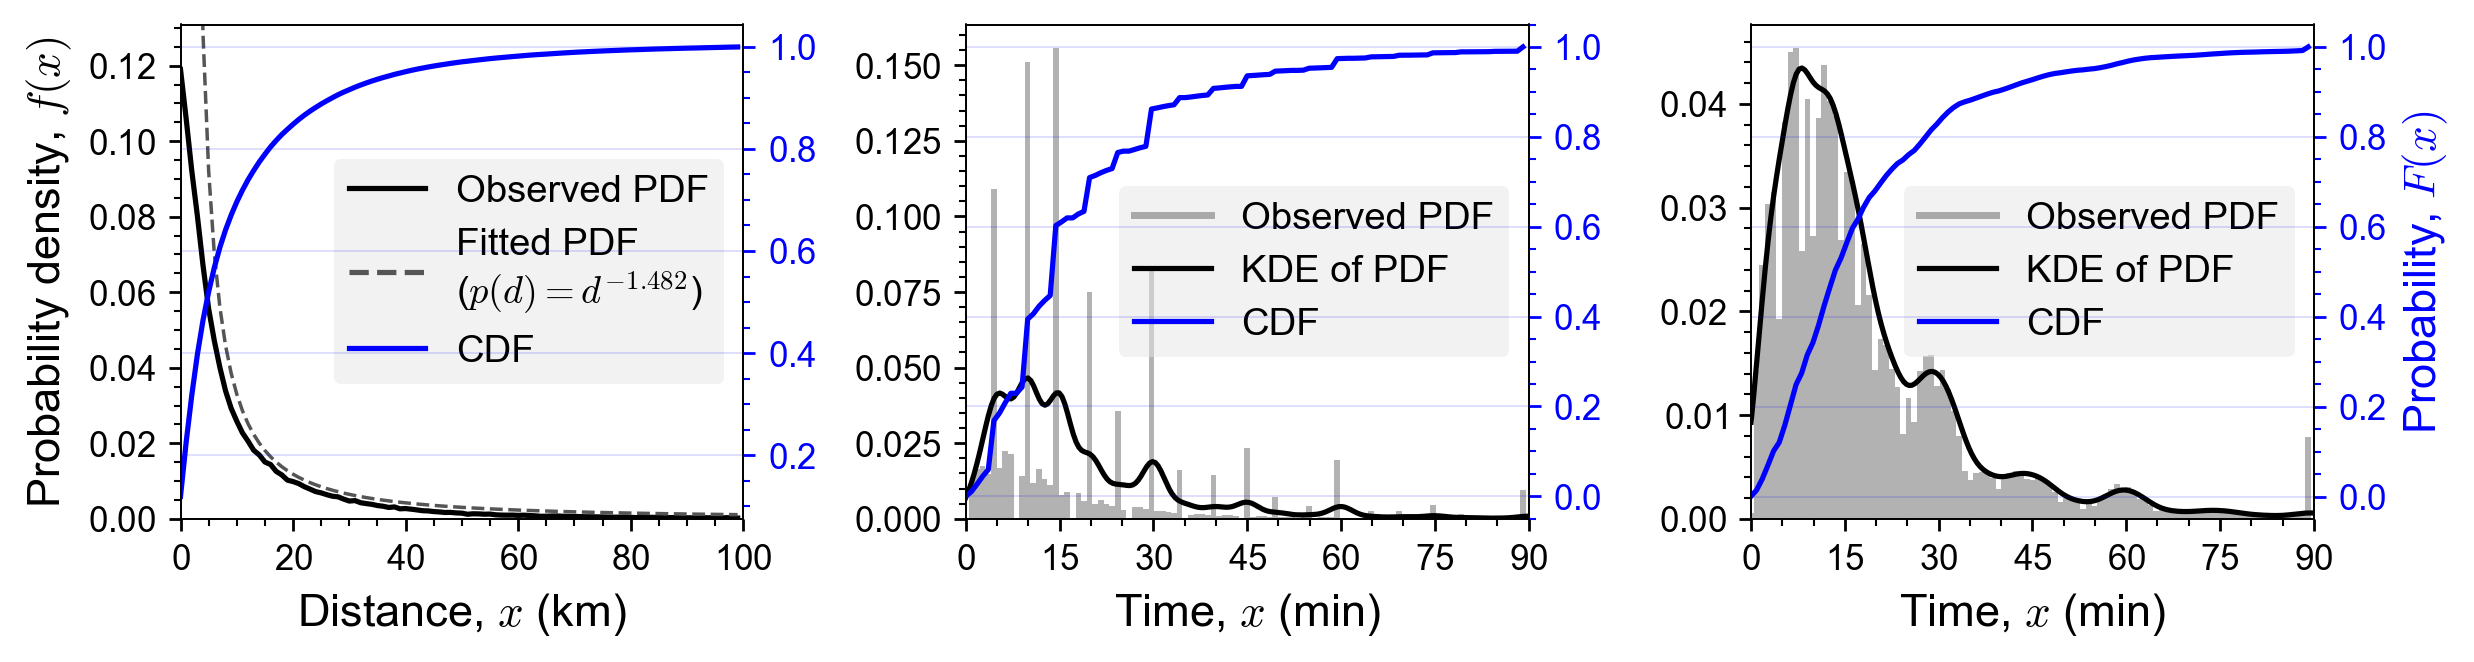

In [10]:
def fig_deterrence_distr(data=trips, size=(10, 2.75), dpi=150):
    def hist(target, vmax=None, bins=100, query=None):
        df = data.query(query) if query else data
        bins = np.linspace(0, vmax, bins + 1)
        y, x = np.histogram(df[target].clip(0, vmax), bins, weights=df.Weight)
        return x[:-1], y / y.sum()
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi)
    line = lambda label, **kw: mpl.lines.Line2D([0], [0], label=label, **kw)
    ## Distance
    ax = pplot(axes[0], xlab='Distance, $x$ (km)', yminor=0, xlim=(0, 100),
               ylab='Probability density, $f(x)$', gridcolor='none')
    x, y = hist('Distance', 100)
    ax.set_ylim(ymax=y.max() * 1.1)
    ax.plot(x, y, color='k')
    reg = LinearRegression(fit_intercept=False)
    lnx, lny = np.log(1e-6 + x).reshape((-1, 1)), np.log(y)
    a = reg.fit(lnx, lny).coef_[0]
    ax.plot(x, (1e-6 + x) ** a, ls='--', lw=1, color='#555')
    twin = pplot(ax.twinx(), yminor=0, gridcolor='b')
    twin.plot(x, y.cumsum(), color='b')
    twin.tick_params(axis='y', which='both', colors='b')
    ax.legend(loc='center right', handles=[
        line('Observed PDF', color='k'),
        line('Fitted PDF\n($p(d)=d^{%.3f}$)' % a, color='#555', ls='--'),
        line('CDF', color='b')])
    ## Original and modified trip durations
    for i, var in enumerate(['RawTime', 'Time']):
        ax = pplot(axes[i + 1], xlab='Time, $x$ (min)',
                   xlim=(0, 90), yminor=0, gridcolor='none')
        x, y = hist(var, 90)
        ax.bar(x, y, color='k', width=0.9, alpha=0.3)
        sns.kdeplot(data[var], ax=ax, bw_adjust=1.75, clip=(0, 90), color='k')
        ax.set_ylabel('')
        ax.set_xticks(np.arange(0, 91, 15))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        twin = pplot(ax.twinx(), yminor=0, gridcolor='b')
        twin.plot(x, y.cumsum(), color='b')
        twin.tick_params(axis='y', which='both', colors='b')
        ax.legend(loc='center right', handles=[
            line('Observed PDF', color='k', alpha=0.3, lw=2),
            line('KDE of PDF', color='k'),
            line('CDF', color='b')])
        if i == 1: twin.set_ylabel('Probability, $F(x)$', color='b')
    plt.tight_layout()
    imsave('Distributions of target variables')

x = fig_deterrence_distr(dpi=250); x # t=0:10

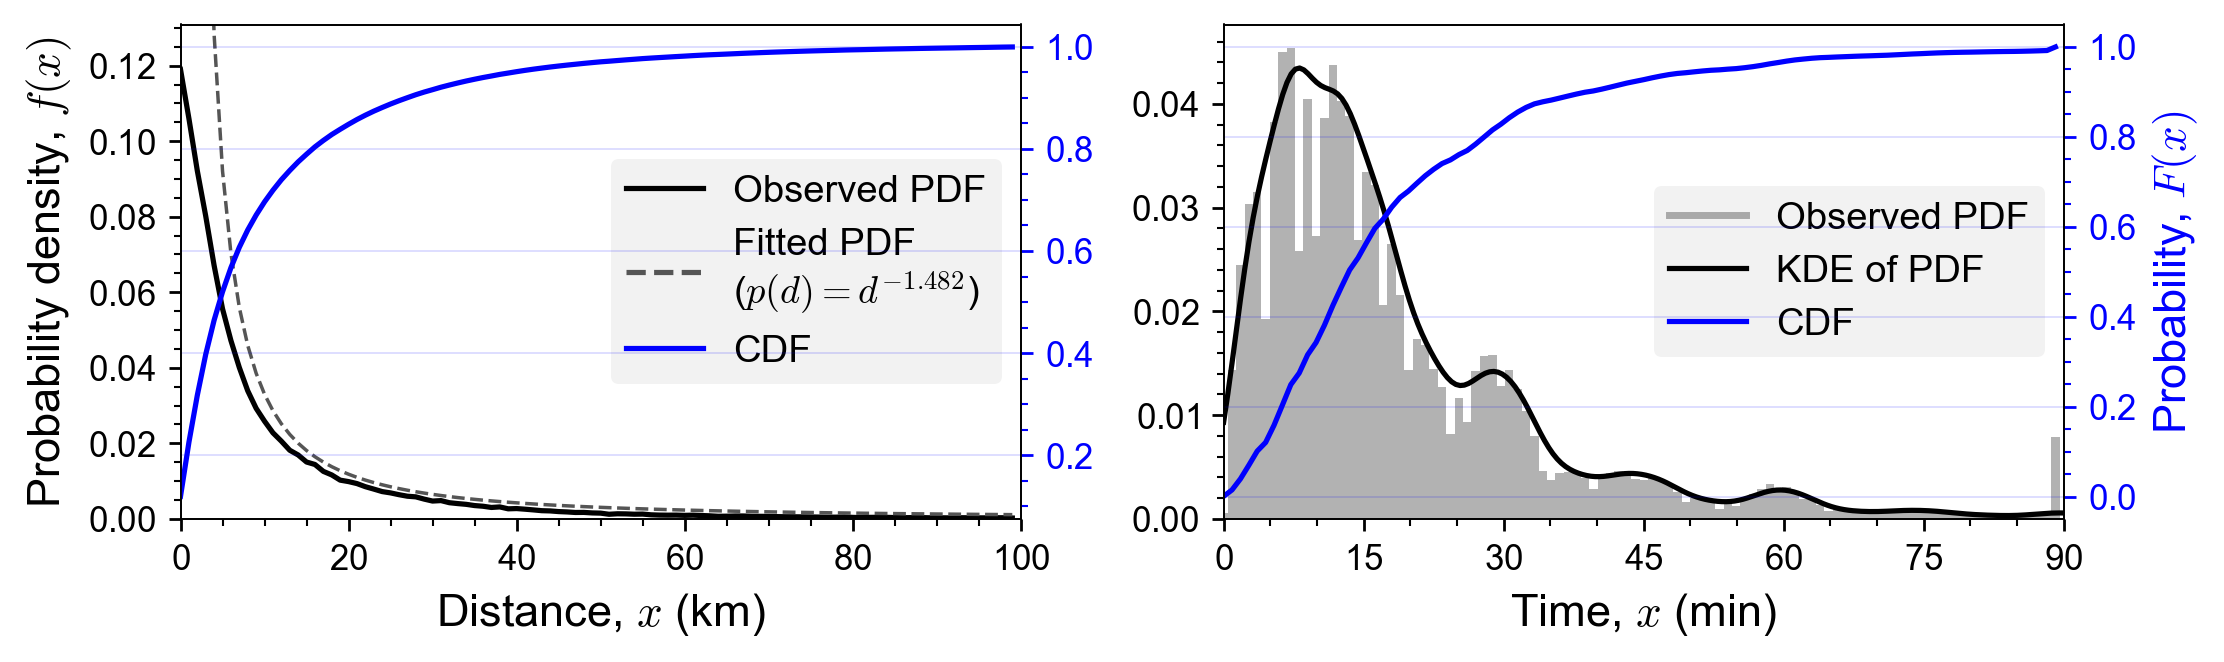

In [11]:
def fig_deterrence_distr(data=trips, size=(9, 2.75), dpi=150):
    def hist(target, vmax=None, bins=100, query=None):
        df = data.query(query) if query else data
        bins = np.linspace(0, vmax, bins + 1)
        y, x = np.histogram(df[target].clip(0, vmax), bins, weights=df.Weight)
        return x[:-1], y / y.sum()
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    line = lambda label, **kw: mpl.lines.Line2D([0], [0], label=label, **kw)
    ## Distance
    ax = pplot(axes[0], xlab='Distance, $x$ (km)', yminor=0, xlim=(0, 100),
               ylab='Probability density, $f(x)$', gridcolor='none')
    x, y = hist('Distance', 100)
    ax.set_ylim(ymax=y.max() * 1.1)
    ax.plot(x, y, color='k')
    reg = LinearRegression(fit_intercept=False)
    lnx, lny = np.log(1e-6 + x).reshape((-1, 1)), np.log(y)
    a = reg.fit(lnx, lny).coef_[0]
    ax.plot(x, (1e-6 + x) ** a, ls='--', lw=1, color='#555')
    twin = pplot(ax.twinx(), yminor=0, gridcolor='b')
    twin.plot(x, y.cumsum(), color='b')
    twin.tick_params(axis='y', which='both', colors='b')
    ax.legend(loc='center right', handles=[
        line('Observed PDF', color='k'),
        line('Fitted PDF\n($p(d)=d^{%.3f}$)' % a, color='#555', ls='--'),
        line('CDF', color='b')])
    ## Original and modified trip durations
    ax = pplot(axes[1], xlab='Time, $x$ (min)',
               xlim=(0, 90), yminor=0, gridcolor='none')
    x, y = hist('Time', 90)
    ax.bar(x, y, color='k', width=0.9, alpha=0.3)
    sns.kdeplot(data['Time'], ax=ax, bw_adjust=1.75, clip=(0, 90), color='k')
    ax.set_ylabel('')
    ax.set_xticks(np.arange(0, 91, 15))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    twin = pplot(ax.twinx(), yminor=0, gridcolor='b')
    twin.plot(x, y.cumsum(), color='b')
    twin.tick_params(axis='y', which='both', colors='b')
    ax.legend(loc='center right', handles=[
        line('Observed PDF', color='k', alpha=0.3, lw=2),
        line('KDE of PDF', color='k'),
        line('CDF', color='b')])
    twin.set_ylabel('Probability, $F(x)$', color='b')
    plt.tight_layout()
    imsave('Distributions of target variables')

x = fig_deterrence_distr(dpi=250); x # t=0:10